In [1]:
import os
import cv2
import glob
import numpy as np
from PIL import Image
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from keras_unet.utils import get_augmented
from keras_unet.models import custom_unet
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras_unet.metrics import dice_coef


Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
img_d_ap = glob.glob("Damaged/*/AP/AP.jpg")
img_n_ap = glob.glob("Normal/*/AP/AP.jpg")

masks_d_ap_pedicle = glob.glob("Damaged/*/AP/Ap_Pedicle.png")
masks_d_ap_spinous = glob.glob("Damaged/*/AP/Ap_Spinous_Process.png")
masks_d_ap_vertebra = glob.glob("Damaged/*/AP/Ap_Vertebra.png")

masks_n_ap_pedicle = glob.glob("Normal/*/AP/Ap_Pedicle.png")
masks_n_ap_spinous = glob.glob("Damaged/*/AP/Ap_Spinous_Process.png")
masks_n_ap_vertebra = glob.glob("Damaged/*/AP/Ap_Vertebra.png")


In [5]:
img_d_lat = glob.glob("Damaged/*/LAT/LAT.jpg")
img_n_lat = glob.glob("Normal/*/LAT/LAT.jpg")

masks_d_lat_ant = glob.glob("Damaged/*/LAT/Lat_Anterior_Vertebral_Line.png")
masks_d_lat_dis = glob.glob("Damaged/*/LAT/Lat_Disk_Height.png")
masks_d_lat_pos = glob.glob("Damaged/*/LAT/Lat_Posterior_Vertebral_Line.png")
masks_d_lat_spi = glob.glob("Damaged/*/LAT/Lat_Spinous_Process.png")
masks_d_lat_ver = glob.glob("Damaged/*/LAT/Lat_Vertebra.png")

masks_n_lat_ant = glob.glob("Normal/*/LAT/Lat_Anterior_Vertebral_Line.png")
masks_n_lat_dis = glob.glob("Damaged/*/LAT/Lat_Disk_Height.png")
masks_n_lat_pos = glob.glob("Damaged/*/LAT/Lat_Posterior_Vertebral_Line.png")
masks_n_lat_spi = glob.glob("Damaged/*/LAT/Lat_Spinous_Process.png")
masks_n_lat_ver = glob.glob("Damaged/*/LAT/Lat_Vertebra.png")

In [6]:
orgs_ap = img_d_ap + img_n_ap
masks_ap_pedicle = masks_d_ap_pedicle + masks_n_ap_pedicle
masks_ap_spinous = masks_d_ap_spinous + masks_n_ap_spinous
masks_ap_vertebra = masks_d_ap_vertebra + masks_n_ap_vertebra

In [7]:
orgs_lat = img_d_lat + img_n_lat
masks_lat_ant = masks_d_lat_ant + masks_n_lat_ant
masks_lat_dis = masks_d_lat_dis + masks_n_lat_dis
masks_lat_pos = masks_d_lat_pos + masks_n_lat_pos
masks_lat_spi = masks_d_lat_spi + masks_n_lat_spi
masks_lat_ver = masks_d_lat_ver + masks_n_lat_ver

In [8]:
def image_np(img, mask):
    imgs_list = []
    masks_list = []
    for image, mask in zip(img, mask):

        imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))

        im = Image.open(mask).convert('L').resize((512,512)) 
        masks_list.append(np.array(im))
    
    return imgs_list, masks_list

#imgs_np_ap_pedicle = np.asarray(imgs_list)
#masks_np_ap_pedicle = np.asarray(masks_list)

In [20]:
#AP
imgs_ap, masks_ap_pedicle = image_np(orgs_ap, masks_ap_pedicle)
imgs_ap, masks_ap_spinous = image_np(orgs_ap, masks_ap_spinous)
imgs_ap, masks_ap_vertebra = image_np(orgs_ap, masks_ap_vertebra)


In [ ]:
imgs_np_ap = np.asarray(imgs_ap)
masks_np_ap_pedicle = np.asarray(masks_ap_pedicle)
masks_np_ap_spinous = np.asarray(masks_ap_spinous)
masks_np_ap_vertebra = np.asarray(masks_ap_vertebra)

In [9]:
#LAT
imgs_lat, masks_lat_ant = image_np(orgs_lat, masks_lat_ant)
imgs_lat, masks_lat_dis = image_np(orgs_lat, masks_lat_dis)
imgs_lat, masks_lat_pos = image_np(orgs_lat, masks_lat_pos)
imgs_lat, masks_lat_spi = image_np(orgs_lat, masks_lat_spi)
imgs_lat, masks_lat_ver = image_np(orgs_lat, masks_lat_ver)


In [11]:
imgs_np_lat = np.asarray(imgs_lat)
masks_np_lat_ant = np.asarray(masks_lat_ant)
masks_np_lat_dis = np.asarray(masks_lat_dis)
masks_np_lat_pos = np.asarray(masks_lat_pos)
masks_np_lat_spi = np.asarray(masks_lat_spi)
masks_np_lat_ver = np.asarray(masks_lat_ver)

In [26]:
#AP
print(imgs_np_ap.shape, masks_np_ap_pedicle.shape)

(650, 512, 512) (668, 512, 512)


In [13]:
#LAT
print(imgs_np_lat.shape, masks_np_lat_ant.shape)
print(imgs_np_lat.shape, masks_np_lat_dis.shape)
print(imgs_np_lat.shape, masks_np_lat_pos.shape)
print(imgs_np_lat.shape, masks_np_lat_spi.shape)
print(imgs_np_lat.shape, masks_np_lat_ver.shape)

(650, 512, 512) (657, 512, 512)
(650, 512, 512) (640, 512, 512)
(650, 512, 512) (638, 512, 512)
(650, 512, 512) (634, 512, 512)
(650, 512, 512) (650, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

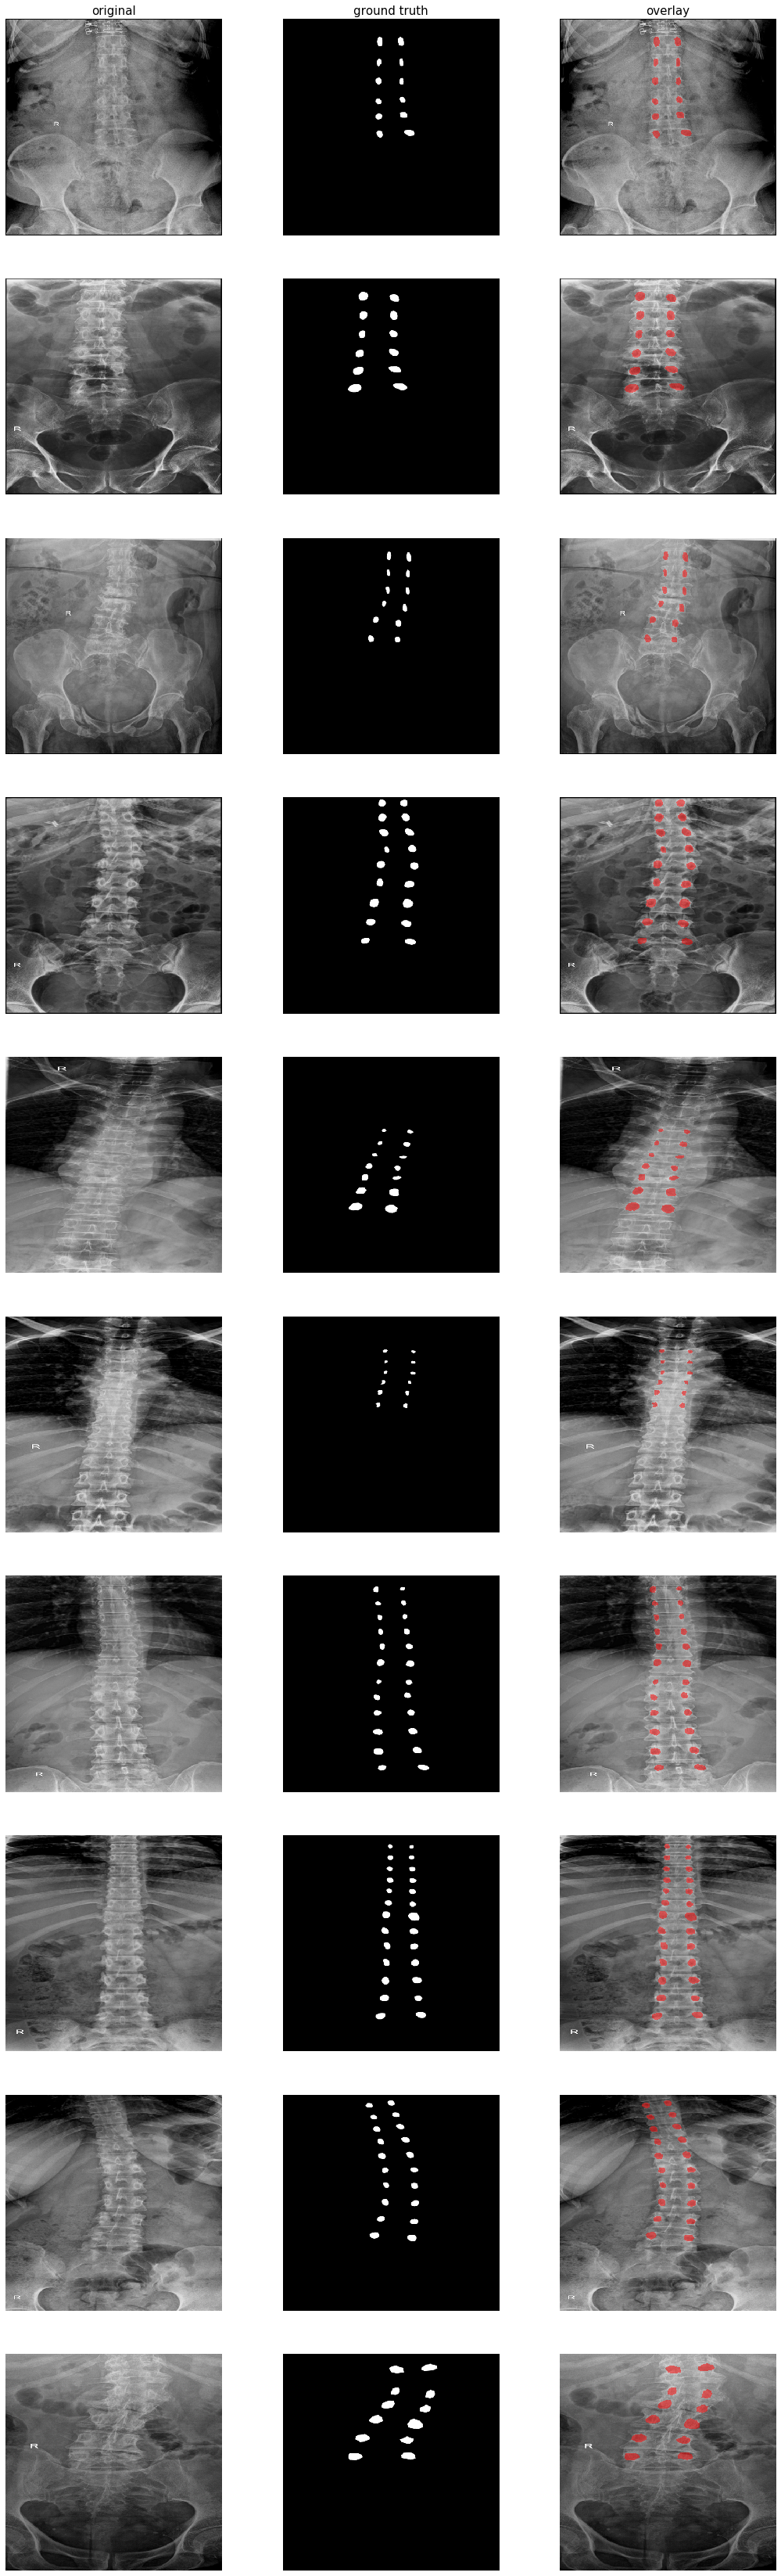

AttributeError: 'NoneType' object has no attribute 'savefig'

In [27]:
a = plot_imgs(org_imgs=imgs_np_ap, mask_imgs=masks_np_ap_pedicle, nm_img_to_plot=10, figsize=6)
a.savefig("t.png")

In [14]:
def prepare(img, mask, model_name):
    x = np.asarray(img, dtype=np.float32)/255
    y = np.asarray(mask, dtype=np.float32)/255
    y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    print(x.shape, y.shape)
    print(x.shape, y.shape)

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)
    
    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_val: ", x_val.shape)
    print("y_val: ", y_val.shape)

    train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))
    input_shape = x_train[0].shape
    model = custom_unet(input_shape, use_batch_norm=False, num_classes=1, filters=64, dropout=0.2, output_activation='sigmoid')

    model_filename = model_name
    callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor='val_loss', save_best_only=True)

    model.compile(optimizer=SGD(lr=0.01, momentum=0.99),loss='binary_crossentropy', metrics=[dice_coef])

    return model, train_gen, x_val, y_val, callback_checkpoint

In [20]:
#AP
#model_pedicle, train_gen_pedicle = prepare(imgs_np_ap, masks_np_ap_pedicle)
#model_spinous, train_gen_spinous = prepare(imgs_np_ap, masks_np_ap_spinous)
#model_spinous, train_gen_spinous, x_val, y_val, callback_checkpoint = prepare(imgs_np_ap, masks_np_ap_spinous, 'segm_model_v0_spinous.h5')
#model_vertebra, train_gen_vertebra, x_val, y_val, callback_checkpoint = prepare(imgs_np_ap, masks_np_ap_vertebra, 'segm_model_v0_vertebra.h5')

In [29]:
#LAT

#model_ant, train_gen_ant, x_val, y_val, callback_checkpoint = prepare(imgs_np_lat, masks_np_lat_ant, 'segm_model_v0_ant.h5')
#model_dis, train_gen_dis, x_val, y_val, callback_checkpoint = prepare(imgs_np_lat, masks_np_lat_dis, 'segm_model_v0_dis.h5')
#model_pos, train_gen_pos, x_val, y_val, callback_checkpoint = prepare(imgs_np_lat, masks_np_lat_pos, 'segm_model_v0_pos.h5')
model_spi, train_gen_spi, x_val, y_val, callback_checkpoint = prepare(imgs_np_lat, masks_np_lat_spi, 'segm_model_v0_spi.h5')
#model_ver, train_gen_ver, x_val, y_val, callback_checkpoint = prepare(imgs_np_lat, masks_np_lat_ver, 'segm_model_v0_ver.h5')

(650, 512, 512, 1) (634, 512, 512, 1)
(650, 512, 512, 1) (634, 512, 512, 1)


ValueError: Found input variables with inconsistent numbers of samples: [650, 634]

In [22]:
history = model_ver.fit_generator(
    train_gen_ver,
    steps_per_epoch=100,
    epochs=500,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

1 - val_dice_coef: 0.1660

Epoch 00402: val_loss did not improve from 0.23614
Epoch 403/500
100/100 [==============================] - 42s 416ms/step - loss: 0.2450 - dice_coef: 0.1950 - val_loss: 0.2360 - val_dice_coef: 0.1732

Epoch 00403: val_loss improved from 0.23614 to 0.23603, saving model to segm_model_v0_ver.h5
Epoch 404/500
100/100 [==============================] - 41s 414ms/step - loss: 0.2487 - dice_coef: 0.1935 - val_loss: 0.2380 - val_dice_coef: 0.1896

Epoch 00404: val_loss did not improve from 0.23603
Epoch 405/500
100/100 [==============================] - 42s 416ms/step - loss: 0.2488 - dice_coef: 0.1991 - val_loss: 0.2381 - val_dice_coef: 0.1714

Epoch 00405: val_loss did not improve from 0.23603
Epoch 406/500
100/100 [==============================] - 42s 417ms/step - loss: 0.2434 - dice_coef: 0.1912 - val_loss: 0.2410 - val_dice_coef: 0.1573

Epoch 00406: val_loss did not improve from 0.23603
Epoch 407/500
100/100 [==============================] - 42s 416ms/step 

In [27]:
def plot_segm_histor(history, metrics=['dice_coef', 'val_dice_coef'], losses=['loss', 'val_loss']):
    # summarize history for iou
    plt.figure(figsize=(12,6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle('Metrics over epochs - Vertebra-LAT', fontsize=20)
    plt.ylabel('Metric', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    #plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    #plt.xticks(fontsize=35)
    plt.legend(metrics, loc='center right', fontsize=15)
    
    plt.savefig('Vertebra-LAT_dice.png', format = 'png', dpi = 1200)
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(12,6))    
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle('loss over epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    #plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    #plt.xticks(fontsize=35)
    plt.legend(losses, loc='center right', fontsize=15)
    
    plt.savefig('Vertebra-LAT_loss.png', format = 'png', dpi = 1200)
    plt.show()

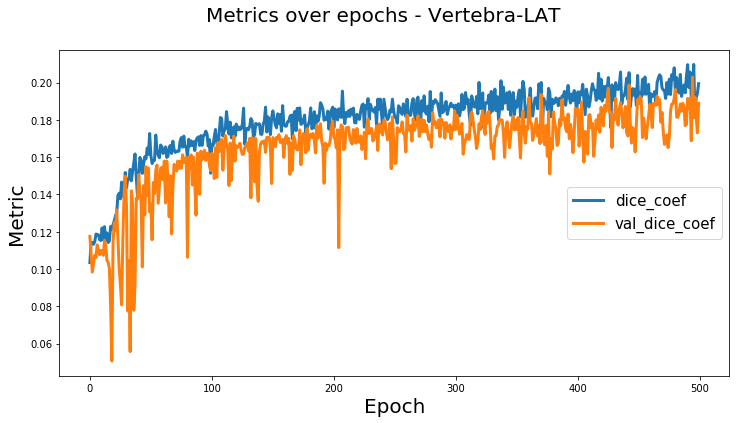

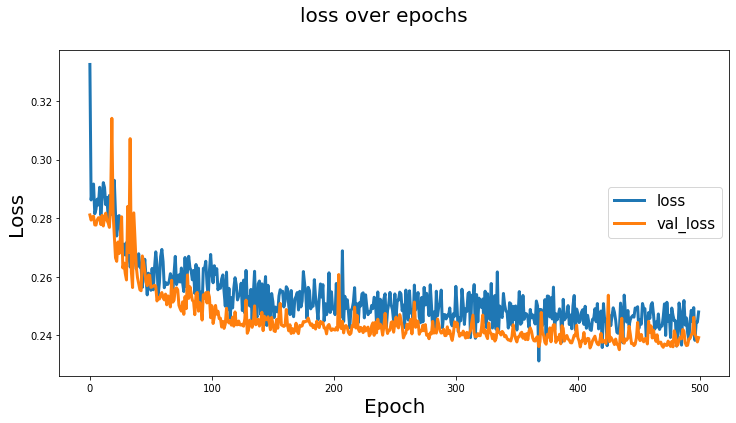

In [28]:
#from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt
plot_segm_histor(history)

In [ ]:
%tensorboard --logdir logs